# DenseNet-121: CIFAR-10 + PyTorch with _fine-tuning_

using ```albumentations``` and learning rate scheduler. To read the research paper, refer to _Densely Connected Convolutional Networks_ by 
Gao Huang et al.

[Finetuning torchvision CNN architectures reference](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models
# import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2

C:\Users\arjun\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU
Available device is cuda


In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 40

In [5]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)

In [6]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label
    

In [7]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    download = True, transform = transform_train
)

val_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    download = True, transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Define train and validate loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size = batch_size,
    shuffle = True
    )

In [9]:
print(f"len(train_dataset) = {len(train_dataset)} & len(val_dataset) = {len(val_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(val_loader) = {len(val_loader)}")

# Sanity check-
len(train_dataset) / batch_size, len(val_dataset) / batch_size

len(train_dataset) = 50000 & len(val_dataset) = 10000
len(train_loader) = 196 & len(val_loader) = 40


(195.3125, 39.0625)

### Use pre-trained _SqueezeNet-1.1_ CNN

In [10]:
# Load pre-trained DenseNet-121 model-
model = models.densenet121(weights = torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)

# Side note:
# ResNet-18 model size = 44.6 MB
# ResNet-50 model size = 97.7 MB
# SqueezeNet-1.1 model size = 4.72 MB
# DenseNet-121 model size = 30.8 MB

In [11]:
# Remove (2x2) pool since CIFAR-10 images are small and don't need it-
del model.features.pool0

In [12]:
# Modify output layer to have 10 instead of 1000 output neurons-
model.classifier = nn.Linear(
    in_features = 1024, out_features = 10,
    bias = True
)

In [13]:
# Sanity check-
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1

In [14]:
# Sanity check-
model.classifier

Linear(in_features=1024, out_features=10, bias=True)

In [15]:
# Place model on GPU-
model = model.to(device)

In [16]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"Total number of parameters in DenseNet-121 CNN = {tot_params}")

Total number of parameters in DenseNet-121 CNN = 6964106


In [17]:
# Define cost function-
loss = nn.CrossEntropyLoss()

# Learning rate - Observe that all parameters are being optimized-
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

#### Note

All layer weights are trained instead of freezing some layers as feature extractors and training newly added layers.

In [18]:
# Learning rate scheduler - Decay LR by a factor of 0.1 every 15 epochs-
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)

In [19]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()

def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()
    

In [20]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 80

In [21]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = val_loader,
        test_dataset = val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.5f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    exp_lr_scheduler.step()
    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "DenseNet121_best_model.pth")
        

Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.51batch/s, val_acc=65.6, val_loss=0.984]



epoch: 1 training loss = 1.6686, training accuracy = 40.52%, val_loss = 0.9837, val_accuracy = 65.57% & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.57batch/s, val_acc=75, val_loss=0.717]



epoch: 2 training loss = 1.0814, training accuracy = 61.96%, val_loss = 0.7168, val_accuracy = 74.96% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.54batch/s, val_acc=79.3, val_loss=0.596]



epoch: 3 training loss = 0.8867, training accuracy = 69.08%, val_loss = 0.5963, val_accuracy = 79.32% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.62batch/s, val_acc=82.4, val_loss=0.516]



epoch: 4 training loss = 0.7894, training accuracy = 72.50%, val_loss = 0.5156, val_accuracy = 82.44% & LR = 0.00100

Saving model with highest val_acc = 82.44%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.61batch/s, val_acc=83.8, val_loss=0.473]



epoch: 5 training loss = 0.7192, training accuracy = 74.67%, val_loss = 0.4728, val_accuracy = 83.81% & LR = 0.00100

Saving model with highest val_acc = 83.81%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.57batch/s, val_acc=85.1, val_loss=0.439]



epoch: 6 training loss = 0.6579, training accuracy = 76.87%, val_loss = 0.4389, val_accuracy = 85.07% & LR = 0.00100

Saving model with highest val_acc = 85.07%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.55batch/s, val_acc=86.2, val_loss=0.407]



epoch: 7 training loss = 0.6220, training accuracy = 78.10%, val_loss = 0.4070, val_accuracy = 86.18% & LR = 0.00100

Saving model with highest val_acc = 86.18%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.44batch/s, val_acc=86.9, val_loss=0.389]



epoch: 8 training loss = 0.5836, training accuracy = 79.43%, val_loss = 0.3887, val_accuracy = 86.88% & LR = 0.00100

Saving model with highest val_acc = 86.88%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.04batch/s, val_acc=87.3, val_loss=0.372]



epoch: 9 training loss = 0.5554, training accuracy = 80.61%, val_loss = 0.3718, val_accuracy = 87.33% & LR = 0.00100

Saving model with highest val_acc = 87.33%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.58batch/s, val_acc=87.6, val_loss=0.369]



epoch: 10 training loss = 0.5386, training accuracy = 81.22%, val_loss = 0.3688, val_accuracy = 87.57% & LR = 0.00100

Saving model with highest val_acc = 87.57%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.67batch/s, val_acc=88.5, val_loss=0.343]



epoch: 11 training loss = 0.5081, training accuracy = 82.36%, val_loss = 0.3432, val_accuracy = 88.54% & LR = 0.00100

Saving model with highest val_acc = 88.54%



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 17.54batch/s, val_acc=88.8, val_loss=0.33]



epoch: 12 training loss = 0.4819, training accuracy = 83.15%, val_loss = 0.3302, val_accuracy = 88.82% & LR = 0.00100

Saving model with highest val_acc = 88.82%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.61batch/s, val_acc=89.1, val_loss=0.322]



epoch: 13 training loss = 0.4685, training accuracy = 83.67%, val_loss = 0.3221, val_accuracy = 89.10% & LR = 0.00100

Saving model with highest val_acc = 89.10%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.60batch/s, val_acc=89.3, val_loss=0.318]



epoch: 14 training loss = 0.4492, training accuracy = 84.36%, val_loss = 0.3182, val_accuracy = 89.30% & LR = 0.00100

Saving model with highest val_acc = 89.30%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.60batch/s, val_acc=89.4, val_loss=0.313]



epoch: 15 training loss = 0.4350, training accuracy = 84.81%, val_loss = 0.3131, val_accuracy = 89.38% & LR = 0.00100

Saving model with highest val_acc = 89.38%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.58batch/s, val_acc=89.8, val_loss=0.302]



epoch: 16 training loss = 0.4160, training accuracy = 85.55%, val_loss = 0.3017, val_accuracy = 89.76% & LR = 0.00010

Saving model with highest val_acc = 89.76%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.66batch/s, val_acc=89.7, val_loss=0.301]



epoch: 17 training loss = 0.4122, training accuracy = 85.59%, val_loss = 0.3011, val_accuracy = 89.74% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.69batch/s, val_acc=89.9, val_loss=0.298]



epoch: 18 training loss = 0.4060, training accuracy = 85.91%, val_loss = 0.2983, val_accuracy = 89.94% & LR = 0.00010

Saving model with highest val_acc = 89.94%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.69batch/s, val_acc=89.8, val_loss=0.299]



epoch: 19 training loss = 0.4034, training accuracy = 86.11%, val_loss = 0.2993, val_accuracy = 89.77% & LR = 0.00010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.61batch/s, val_acc=89.6, val_loss=0.3]



epoch: 20 training loss = 0.4068, training accuracy = 85.93%, val_loss = 0.3002, val_accuracy = 89.64% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.64batch/s, val_acc=89.7, val_loss=0.297]



epoch: 21 training loss = 0.3971, training accuracy = 86.18%, val_loss = 0.2974, val_accuracy = 89.74% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.66batch/s, val_acc=89.9, val_loss=0.296]



epoch: 22 training loss = 0.3946, training accuracy = 86.14%, val_loss = 0.2955, val_accuracy = 89.92% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.41batch/s, val_acc=89.9, val_loss=0.296]



epoch: 23 training loss = 0.3994, training accuracy = 86.03%, val_loss = 0.2964, val_accuracy = 89.92% & LR = 0.00010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.53batch/s, val_acc=90, val_loss=0.295]



epoch: 24 training loss = 0.3935, training accuracy = 86.16%, val_loss = 0.2948, val_accuracy = 89.97% & LR = 0.00010

Saving model with highest val_acc = 89.97%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.66batch/s, val_acc=90, val_loss=0.293]



epoch: 25 training loss = 0.3980, training accuracy = 86.18%, val_loss = 0.2933, val_accuracy = 90.01% & LR = 0.00010

Saving model with highest val_acc = 90.01%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.65batch/s, val_acc=89.8, val_loss=0.292]



epoch: 26 training loss = 0.3908, training accuracy = 86.29%, val_loss = 0.2921, val_accuracy = 89.83% & LR = 0.00010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.61batch/s, val_acc=90, val_loss=0.291]



epoch: 27 training loss = 0.3946, training accuracy = 86.22%, val_loss = 0.2914, val_accuracy = 90.00% & LR = 0.00010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.57batch/s, val_acc=90, val_loss=0.292]



epoch: 28 training loss = 0.3840, training accuracy = 86.63%, val_loss = 0.2919, val_accuracy = 90.00% & LR = 0.00010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.65batch/s, val_acc=90, val_loss=0.289]



epoch: 29 training loss = 0.3847, training accuracy = 86.67%, val_loss = 0.2888, val_accuracy = 89.99% & LR = 0.00010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.54batch/s, val_acc=90, val_loss=0.291]



epoch: 30 training loss = 0.3879, training accuracy = 86.55%, val_loss = 0.2906, val_accuracy = 89.97% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.58batch/s, val_acc=89.8, val_loss=0.293]



epoch: 31 training loss = 0.3871, training accuracy = 86.41%, val_loss = 0.2932, val_accuracy = 89.83% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.39batch/s, val_acc=90.1, val_loss=0.291]



epoch: 32 training loss = 0.3846, training accuracy = 86.66%, val_loss = 0.2907, val_accuracy = 90.08% & LR = 0.00001

Saving model with highest val_acc = 90.08%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.53batch/s, val_acc=90, val_loss=0.292]



epoch: 33 training loss = 0.3827, training accuracy = 86.71%, val_loss = 0.2916, val_accuracy = 89.95% & LR = 0.00001



Validation: : 100%|██████████████████████████████████████| 40/40 [00:02<00:00, 17.60batch/s, val_acc=90, val_loss=0.29]



epoch: 34 training loss = 0.3827, training accuracy = 86.76%, val_loss = 0.2903, val_accuracy = 90.02% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.62batch/s, val_acc=89.9, val_loss=0.291]



epoch: 35 training loss = 0.3852, training accuracy = 86.48%, val_loss = 0.2909, val_accuracy = 89.93% & LR = 0.00001



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 17.64batch/s, val_acc=90.1, val_loss=0.29]



epoch: 36 training loss = 0.3843, training accuracy = 86.75%, val_loss = 0.2895, val_accuracy = 90.09% & LR = 0.00001

Saving model with highest val_acc = 90.09%



Validation: : 100%|██████████████████████████████████████| 40/40 [00:02<00:00, 17.62batch/s, val_acc=90, val_loss=0.29]



epoch: 37 training loss = 0.3835, training accuracy = 86.69%, val_loss = 0.2898, val_accuracy = 89.99% & LR = 0.00001



Validation: : 100%|██████████████████████████████████████| 40/40 [00:02<00:00, 17.60batch/s, val_acc=90, val_loss=0.29]



epoch: 38 training loss = 0.3846, training accuracy = 86.63%, val_loss = 0.2897, val_accuracy = 89.95% & LR = 0.00001



Validation: : 100%|██████████████████████████████████████| 40/40 [00:02<00:00, 17.54batch/s, val_acc=90, val_loss=0.29]



epoch: 39 training loss = 0.3795, training accuracy = 86.78%, val_loss = 0.2901, val_accuracy = 89.97% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 17.52batch/s, val_acc=90.1, val_loss=0.288]


epoch: 40 training loss = 0.3816, training accuracy = 86.62%, val_loss = 0.2879, val_accuracy = 90.08% & LR = 0.00001



In [22]:
# Save training metrics as Python3 history for later analysis-
with open("DenseNet121_CIFAR10_training_history.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

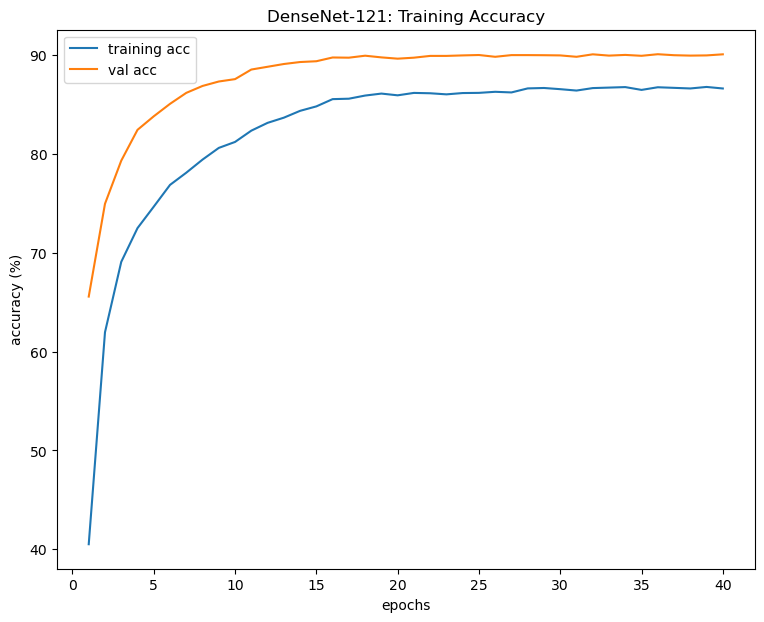

In [23]:
# Visualize ResNet-training-
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("DenseNet-121: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

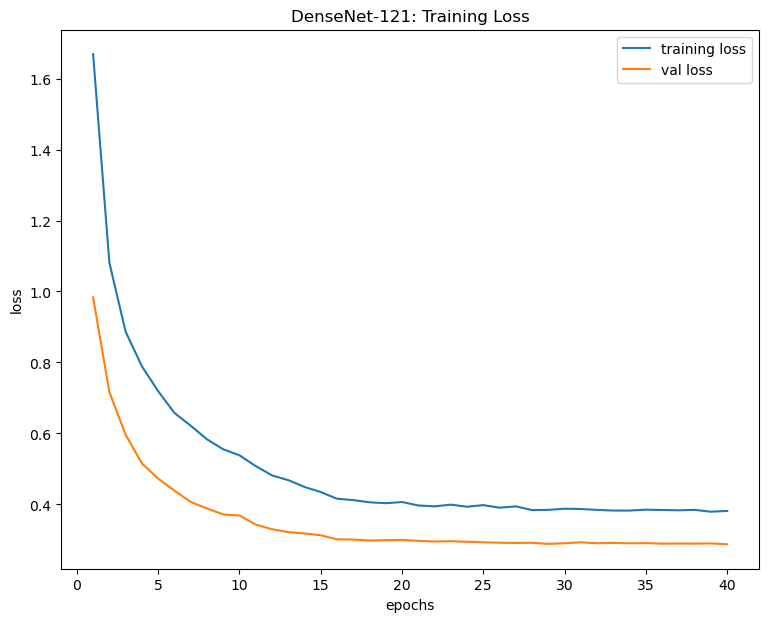

In [24]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("DenseNet-121: Training Loss")
plt.show()

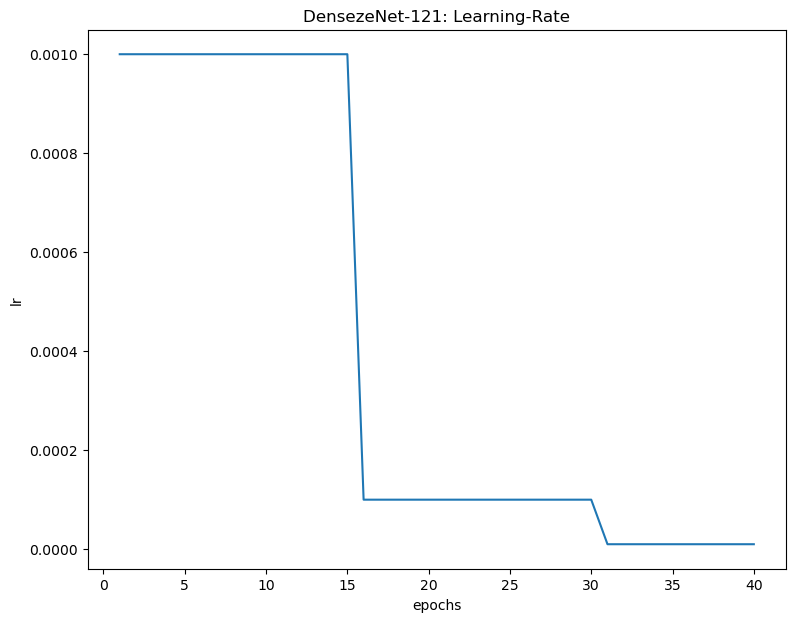

In [25]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("DensezeNet-121: Learning-Rate")
plt.show()